In [37]:
import pandas as pd
import numpy as np


import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation

file = "C:/Users/TYS/Documents/study/Master/INSY662/group project/Real Code/INSY662-Group-Project/Data/complete_dataset_5000.csv"
df = pd.read_csv(file)

In [36]:
df.head

<bound method NDFrame.head of Empty DataFrame
Columns: [ride_id, rideable_type, started_at, ended_at, start_station_name, start_station_id, end_station_name, end_station_id, start_lat, start_lng, end_lat, end_lng, member_casual, tavg, tmin, tmax, prcp, snow, wdir, wspd, wpgt, pres, tsun, day_of_the_week, Holiday, trip_time, distance_traveled, average_speed, month, hour, wind_direction, start_station_cluster, end_station_cluster]
Index: []

[0 rows x 33 columns]>

In [38]:
# Calculate the Z-score for each trip
df['z_score'] = np.abs((df['trip_time'] - df['trip_time'].mean()) / df['trip_time'].std())

# Define a threshold for identifying outliers
z_score_threshold = 3

# Remove outliers based on Z-score
df = df[df['z_score'] <= z_score_threshold]
df.drop('z_score',axis=1,inplace=True)

In [39]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression


# Identify numerical columns (assuming they are the ones with type 'float64')
numerical_cols = df.select_dtypes(include=['float64']).columns.tolist()

# Define our features and target
X = df.drop('rideable_type_electric_bike', axis=1)
X = pd.get_dummies(X,columns=['start_station_cluster','end_station_cluster'])
y = df['rideable_type_electric_bike']

# Standardize the numerical features
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])



In [41]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

sel_ = Lasso(alpha=0.005, random_state=0)
sel_.fit(X_train, y_train)

criteria = sel_.coef_ != 0
selected_features = X.columns[criteria]
selected_features

Index(['start_lat', 'start_lng', 'end_lat', 'end_lng', 'tmin', 'prcp', 'wdir',
       'pres', 'trip_time', 'distance_traveled', 'average_speed', 'hour',
       'member_casual_member', 'day_of_the_week_Saturday',
       'day_of_the_week_Sunday', 'start_station_cluster_3',
       'start_station_cluster_11', 'start_station_cluster_16',
       'start_station_cluster_17', 'start_station_cluster_18',
       'end_station_cluster_18'],
      dtype='object')

<AxesSubplot: >

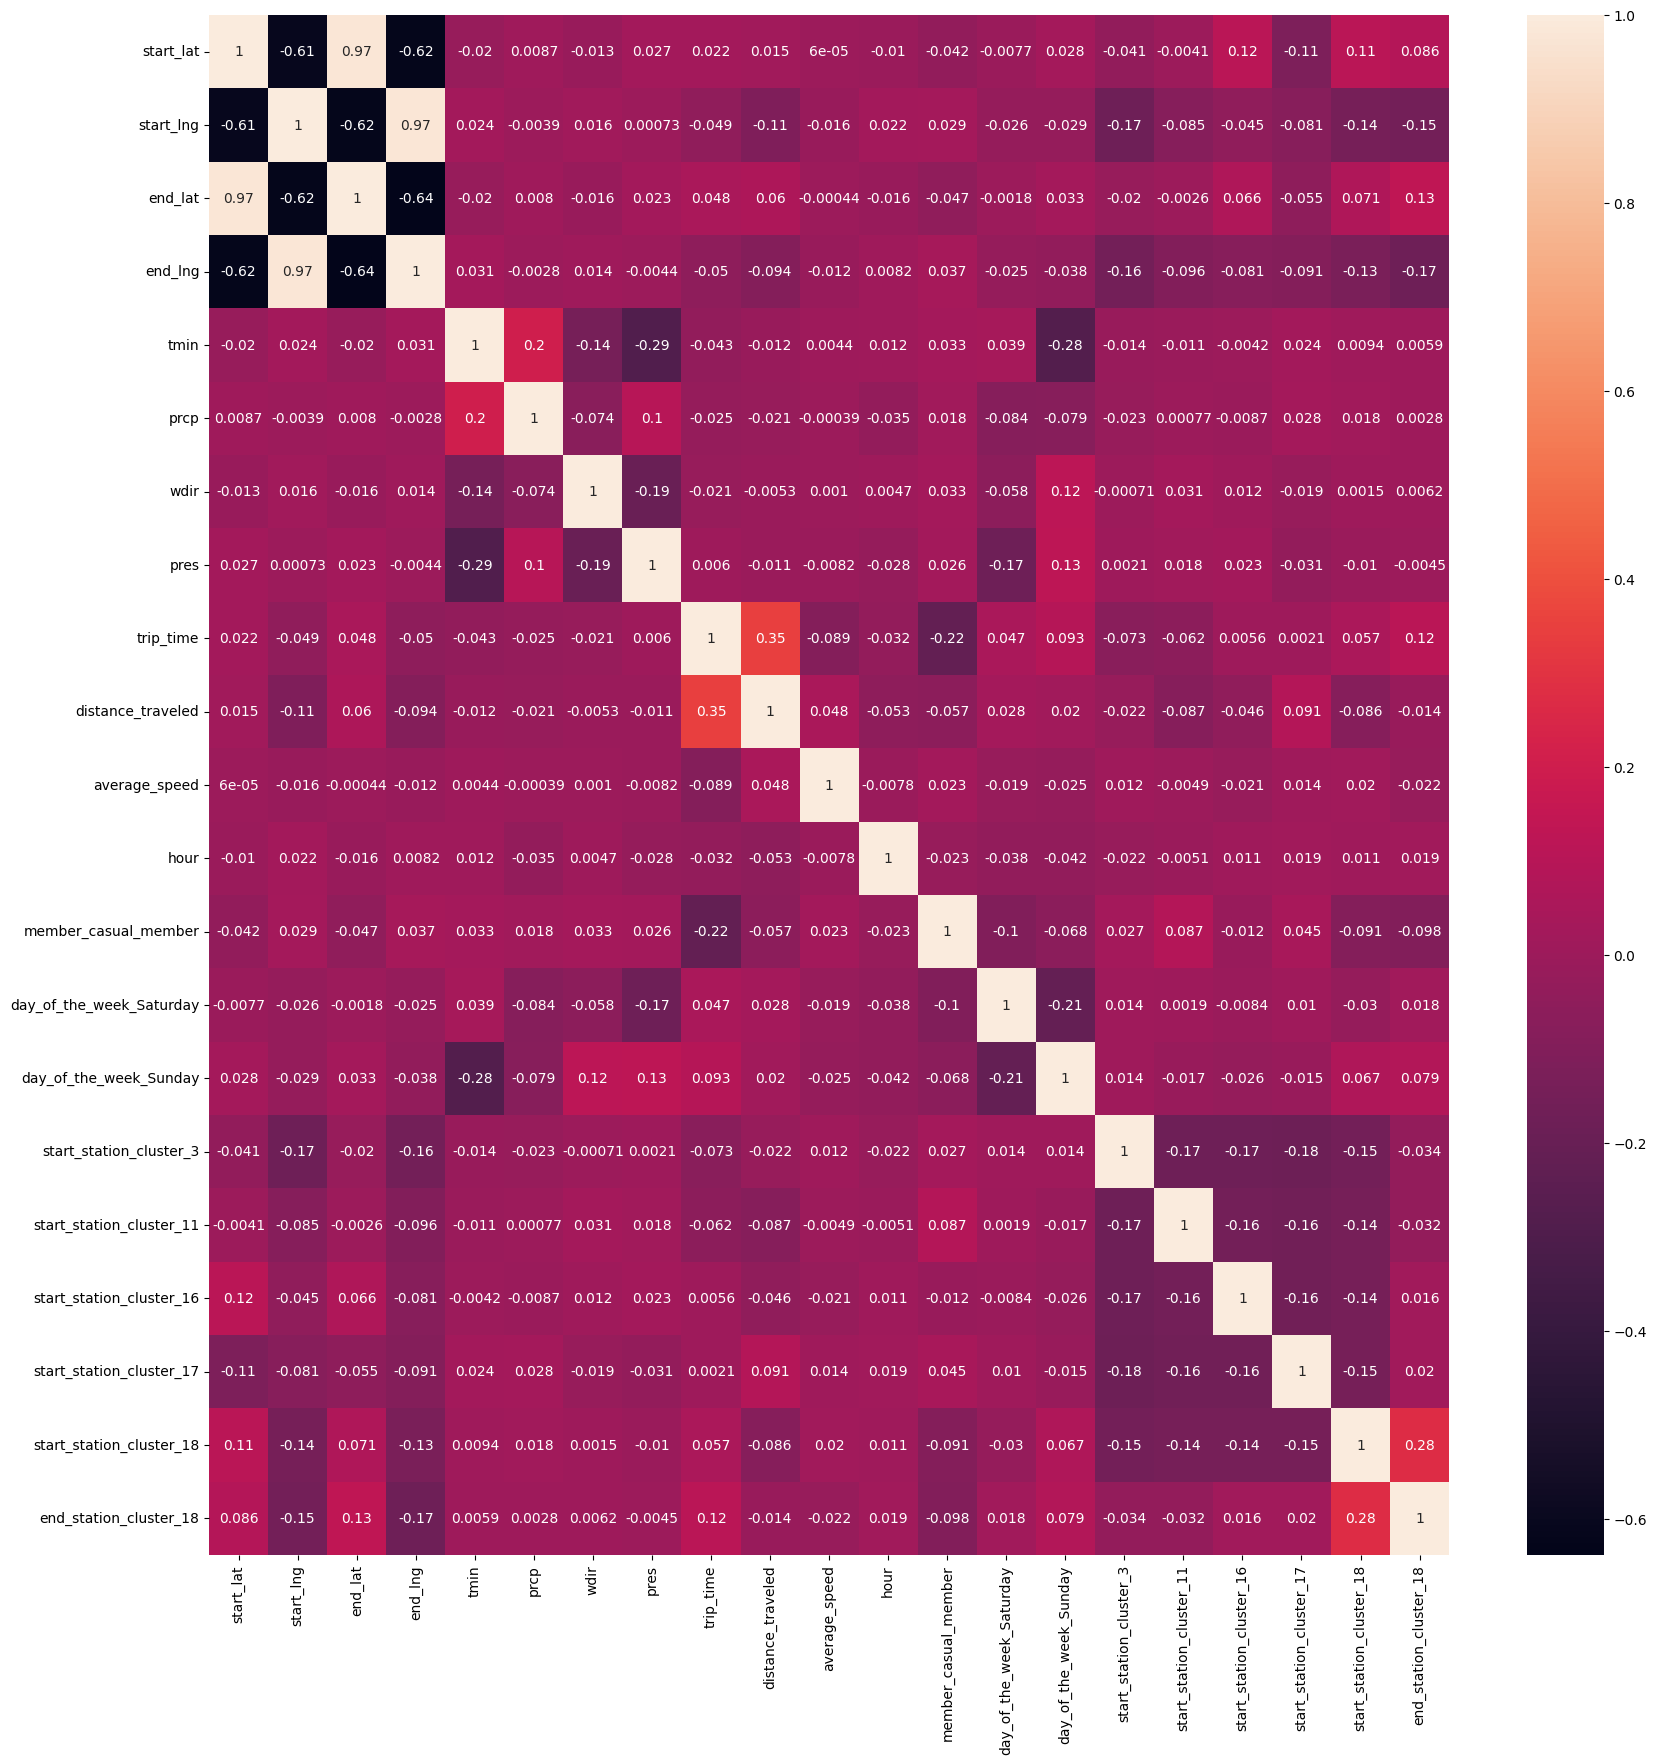

In [42]:
#check the correlation matrix of X
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
X_selected = X[selected_features]
sns.heatmap(X_selected.corr(),annot=True)

In [ ]:
# **** Show different feature selection result with above part, don't run this for now **** #

# Initialize the logistic regression model with L1 penalty, which is Lasso Regularization
logistic = LogisticRegression(penalty='l1', solver='liblinear', random_state=0)

# Feature selection using SelectFromModel
selector = SelectFromModel(estimator=logistic)
X_new = selector.fit_transform(X, y)

# Get the support mask to understand which features are selected
selected_features_mask = selector.get_support()
selected_features = X.columns[selected_features_mask]

selected_features.tolist()

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# First, we'll create a new DataFrame with only the selected features
X_selected = X[selected_features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 5)

lr = LogisticRegression(max_iter=1000) # automatically runs a regularized logistic regression; to control the penalty, add argument 'C = value'; C represents the inverse of lambda
lr_model = lr.fit(X_train,y_train) 

y_pred = lr.predict(X_test)

# Predict probabilities for the test set
y_pred_proba = lr_model.predict_proba(X_test)[:, 1]

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate probabiliy
roc_auc = roc_auc_score(y_test,y_pred_proba)

# Generate a classification report
class_report = classification_report(y_test, y_pred)

accuracy,roc_auc ,class_report

(0.6986986986986987,
 0.7869561714469867,
 '              precision    recall  f1-score   support\n\n           0       0.72      0.58      0.64       464\n           1       0.69      0.81      0.74       535\n\n    accuracy                           0.70       999\n   macro avg       0.70      0.69      0.69       999\nweighted avg       0.70      0.70      0.69       999\n')

The accuracy achieved 72.6%

For class 0 (not electric bike):
Precision: 68% (of all instances predicted as class 0, 68% were actually class 0)
Recall: 42% (of all actual instances of class 0, 0.42% were correctly predicted)
F1-score: 52% (a weighted average of precision and recall for class 0)


For class 1 (electric bike):
Precision: 74% (of all instances predicted as class 1, 74% were actually class 1)
Recall: 89% (of all actual instances of class 1, 89% were correctly predicted)
F1-score: 81% (a weighted average of precision and recall for class 1)

The accuracy achieved 69.9%

For class 0 (not electric bike):
Precision: 68% (of all instances predicted as class 0, 72% were actually class 0)
Recall: 58% (of all actual instances of class 0, 0.58% were correctly predicted)
F1-score: 64% (a weighted average of precision and recall for class 0)


For class 1 (electric bike):
Precision: 74% (of all instances predicted as class 1, 69% were actually class 1)
Recall: 81% (of all actual instances of class 1, 81% were correctly predicted)
F1-score: 74% (a weighted average of precision and recall for class 1)

In [46]:
from sklearn.decomposition import PCA

# Initialize PCA, we'll choose to keep enough components to explain 95% of the variance
pca = PCA(n_components=0.95, random_state=0)

# Fit PCA on the features
pca.fit(X)

# Transform the features using PCA
X_pca = pca.transform(X)

# Number of components
n_components = pca.n_components_

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_.cumsum()

n_components, explained_variance_ratio

(19,
 array([0.53921862, 0.62624716, 0.68419577, 0.731618  , 0.76821942,
        0.80109618, 0.82857314, 0.85268811, 0.87396338, 0.89132494,
        0.90748271, 0.91925733, 0.92612061, 0.93184438, 0.93680575,
        0.94130433, 0.94555315, 0.94969659, 0.95361487]))

In [48]:
# Split the data into training and test sets
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=0)

# Initialize the logistic regression model
logistic_model_pca = LogisticRegression(max_iter=1000, random_state=0)

# Fit the model on the training data
logistic_model_pca.fit(X_train_pca, y_train)

# Predict on the test data
y_pred_pca = logistic_model_pca.predict(X_test_pca)

# Predict probabilities for the test set
y_pred_proba_pca = logistic_model_pca.predict_proba(X_test_pca)[:, 1]

# Calculate probabiliy
roc_auc_pca = roc_auc_score(y_test,y_pred_proba_pca)

# Calculate accuracy
accuracy_pca = accuracy_score(y_test, y_pred_pca)

# Generate a classification report
class_report_pca = classification_report(y_test, y_pred_pca)

n_components_pca = pca.n_components_
explained_variance_ratio_pca = pca.explained_variance_ratio_.cumsum()

accuracy_pca,roc_auc_pca ,class_report_pca, n_components_pca, explained_variance_ratio_pca[-1]

(0.6966966966966966,
 0.7717797124924074,
 '              precision    recall  f1-score   support\n\n           0       0.69      0.58      0.63       449\n           1       0.70      0.79      0.74       550\n\n    accuracy                           0.70       999\n   macro avg       0.70      0.69      0.69       999\nweighted avg       0.70      0.70      0.69       999\n',
 19,
 0.9536148662562277)

The accuracy achieved 69.7%

For class 0 (not electric bike):
Precision: 69% (of all instances predicted as class 0, 69% were actually class 0)
Recall: 58% (of all actual instances of class 0, 0.58% were correctly predicted)
F1-score: 63% (a weighted average of precision and recall for class 0)


For class 1 (electric bike):
Precision: 70% (of all instances predicted as class 1, 70% were actually class 1)
Recall: 79% (of all actual instances of class 1, 79% were correctly predicted)
F1-score: 74% (a weighted average of precision and recall for class 1)